In [1]:
# Cell 1: Import necessary libraries and set style
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from prophet import Prophet
from sklearn.metrics import r2_score

plt.style.use("ggplot")


In [2]:
# Cell 2: Load DataFrames
# Make sure files are in the correct path or adjust paths if needed
try:
    df0 = pd.read_csv("/content/CONVENIENT_global_confirmed_cases.csv")
    df1 = pd.read_csv("/content/CONVENIENT_global_deaths.csv")
    continent = pd.read_csv("/content/continents2.csv")
except FileNotFoundError as e:
    print("File not found. Please check the path:", e)


In [3]:
# Cell 3: Process country data for confirmed cases
# Initialize the 'world' DataFrame with countries and total case counts

world = pd.DataFrame({"Country": df0.columns[1:], "Cases": [df0[country][1:].astype(float).sum() for country in df0.columns[1:]]})
world["Country"] = world["Country"].str.replace(r"[().]", "", regex=True)

# Group cases by country after removing any punctuation
world = world.groupby("Country")["Cases"].sum().reset_index()
continent["name"] = continent["name"].str.upper()


In [4]:
# Cell 4: Categorize cases and map to continent codes
world["Cases Range"] = pd.cut(world["Cases"], bins=[-150000, 50000, 200000, 800000, 1500000, 15000000], labels=["U50K", "50Kto200K", "200Kto800K", "800Kto1.5M", "1.5M+"])

# Map country names to continent codes using 'alpha-3'
alpha = []
for country in world["Country"].str.upper():
    country = "UNITED STATES" if country == "US" else "BRUNEI DARUSSALAM" if country == "BRUNEI" else country
    alpha_code = continent[continent["name"] == country]["alpha-3"].values
    alpha.append(alpha_code[0] if len(alpha_code) > 0 else np.nan)

world["Alpha3"] = alpha


In [5]:
# Cell 5: Plot choropleth map for COVID-19 cases
fig = px.choropleth(world.dropna(), locations="Alpha3", color="Cases Range", projection="mercator", color_discrete_sequence=["white", "khaki", "yellow", "orange", "red"])
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()


In [6]:
# Cell 6: Prepare time-series data for cases and deaths
df = pd.DataFrame()
df["Date"] = df0["Country/Region"][1:]
df["Cases"] = [df0.iloc[i, 1:].astype(float).sum() for i in range(1, len(df0))]
df["Deaths"] = [df1.iloc[i, 1:].astype(float).sum() for i in range(1, len(df1))]
df.set_index("Date", inplace=True)


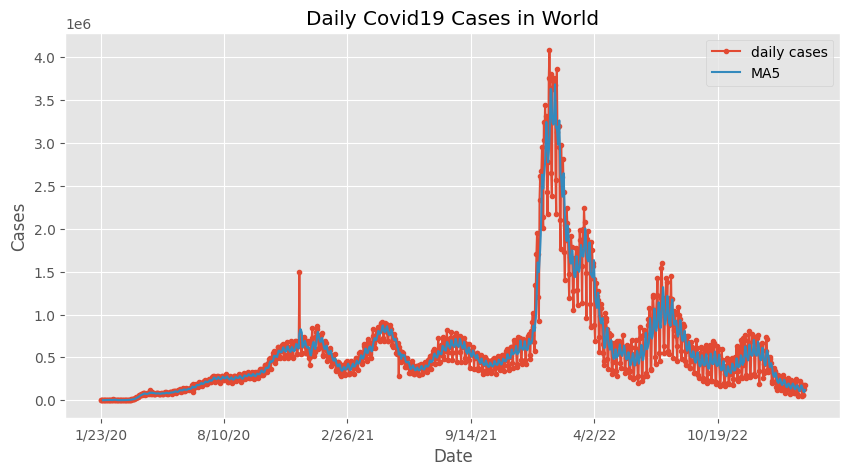

In [7]:
# Cell 7: Plot daily cases and moving average
df["Cases"].plot(title="Daily Covid19 Cases in World", marker=".", figsize=(10, 5), label="daily cases")
df["Cases"].rolling(window=5).mean().plot(figsize=(10, 5), label="MA5")
plt.ylabel("Cases")
plt.legend()
plt.show()


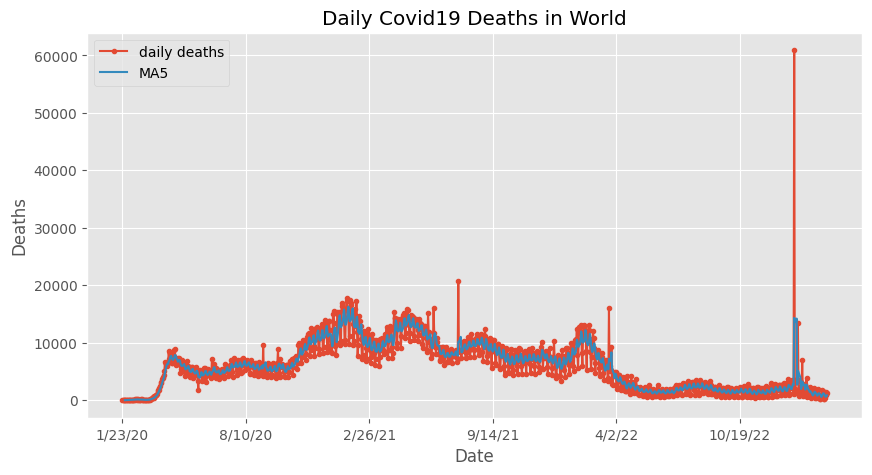

In [8]:
# Cell 8: Plot daily deaths and moving average
df["Deaths"].plot(title="Daily Covid19 Deaths in World", marker=".", figsize=(10, 5), label="daily deaths")
df["Deaths"].rolling(window=5).mean().plot(figsize=(10, 5), label="MA5")
plt.ylabel("Deaths")
plt.legend()
plt.show()


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6qolns91/iuwpfxqe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6qolns91/4d1h8pfg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60238', 'data', 'file=/tmp/tmp6qolns91/iuwpfxqe.json', 'init=/tmp/tmp6qolns91/4d1h8pfg.json', 'output', 'file=/tmp/tmp6qolns91/prophet_model97kh7zcb/prophet_model-20250121184929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:49:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:49:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


R-squared value: 0.6850267872612941


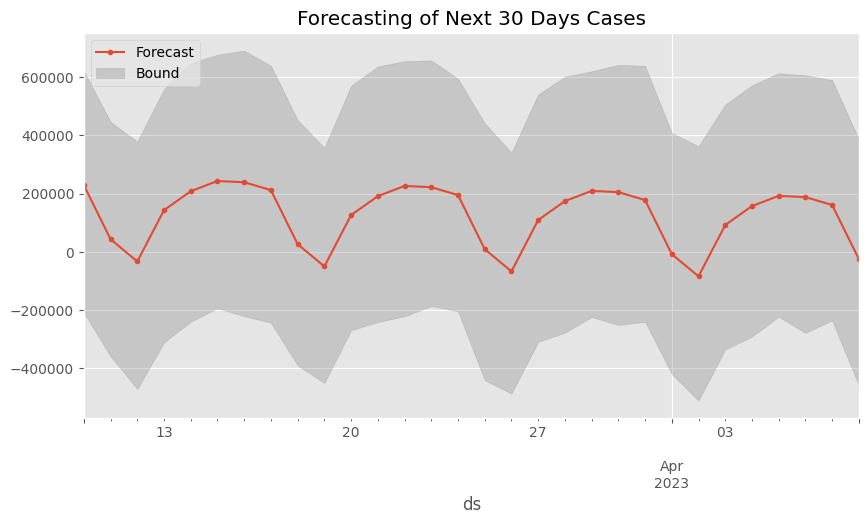

In [9]:
# Cell 9: Define and use Prophet model for forecasting
class FbProphetModel:
    def __init__(self):
        self.model = Prophet(weekly_seasonality=True, daily_seasonality=False, yearly_seasonality=False)

    def fit(self, data):
        self.data = data
        self.model.fit(self.data)

    def forecast(self, periods, freq):
        self.future = self.model.make_future_dataframe(periods=periods, freq=freq)
        self.df_forecast = self.model.predict(self.future)

    def plot(self):
        self.model.plot(self.df_forecast)
        self.model.plot_components(self.df_forecast)

    def calculate_r2(self):
        return r2_score(self.data['y'], self.df_forecast['yhat'][:len(self.data)])

# Prepare data for Prophet model with specified date format to avoid warnings
df_fb = pd.DataFrame({"ds": pd.to_datetime(df.index, format="%m/%d/%y"), "y": df["Cases"].values})

# Set logging to suppress excessive info logs from cmdstanpy
import logging
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

# Define, fit, and forecast with the Prophet model
model = FbProphetModel()
model.fit(df_fb)
model.forecast(30, "D")
print("R-squared value:", model.calculate_r2())

# Plot forecast with confidence interval
forecast = model.df_forecast[["ds", "yhat_lower", "yhat_upper", "yhat"]].tail(30).set_index("ds")
forecast["yhat"].plot(marker=".", figsize=(10, 5))
plt.fill_between(forecast.index, forecast["yhat_lower"], forecast["yhat_upper"], color="gray", alpha=0.3)
plt.legend(["Forecast", "Bound"], loc="upper left")
plt.title("Forecasting of Next 30 Days Cases")
plt.show()
